/tmp/ipykernel_9381/2981200697.py:104: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  J = np.trapz(I**2 + 0.5*C**2 + 0.3*D**2, t_weeks) \



✅ تم إيجاد التحكم المزدوج الأمثل (نظافة + علاج) بنجاح ✅
u_san المثلى (بداية كل أسبوع): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
u_treat المثلى (بداية كل أسبوع): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


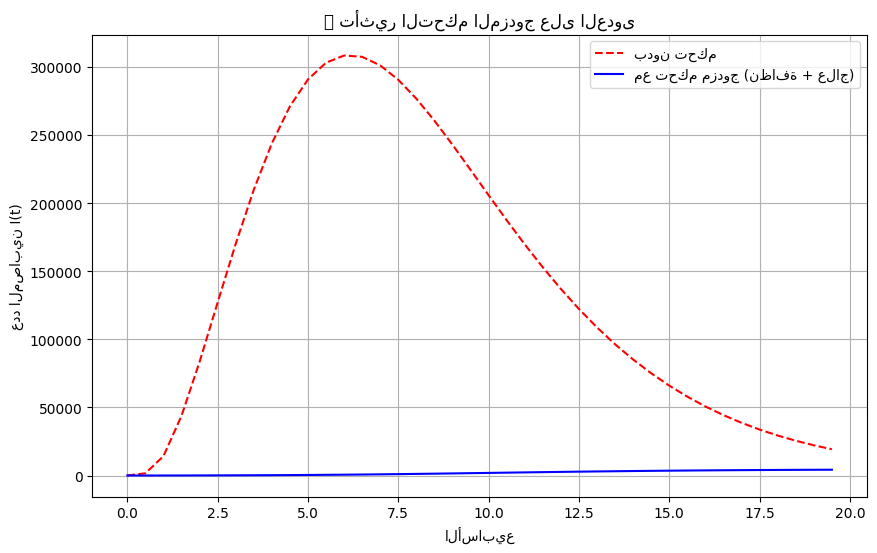

/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


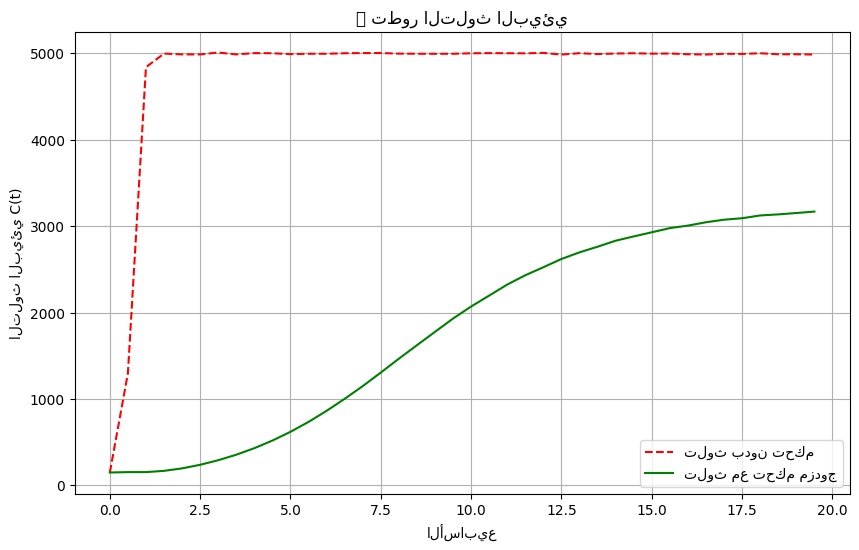

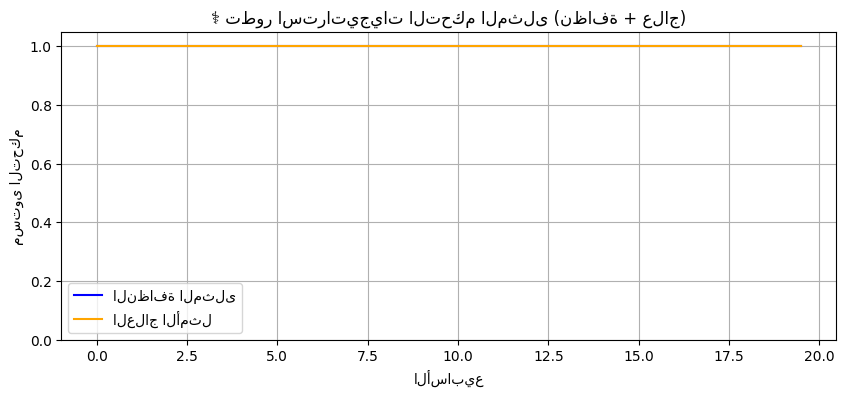

In [1]:
import numpy as np
from dataclasses import dataclass
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# ======================
# نموذج SEIRC-C مع تحكم مزدوج (نظافة + علاج)
# ======================
kappa = 5000

@dataclass
class Params:
    N: float
    beta1: float
    beta2: float
    sigma: float
    gamma: float
    mu: float
    delta: float
    eta: float
    epsilon: float
    kappa: float
    u_vac: float = 0.0
    u_san: float = 0.0
    u_treat: float = 0.0

@dataclass
class ControlGains:
    k_s_to_delta: float = 9.0
    k_s_to_beta2: float = 0.98
    k_s_to_eta:   float = 0.6
    k_s_to_eps:   float = 0.8
    k_v_to_beta:  float = 1.0
    k_t_to_gamma: float = 3.0
    k_t_to_mu:    float = 0.9

# -----------------------
# المعاملات الفعّالة
# -----------------------
def _effective_params(p: Params, k: ControlGains):
    u_v = np.clip(p.u_vac, 0, 1)
    u_s = np.clip(p.u_san, 0, 1)
    u_t = np.clip(p.u_treat, 0, 1)

    susc_scale = (1.0 - k.k_v_to_beta * u_v)
    delta_eff = p.delta * (1.0 + k.k_s_to_delta * u_s)
    beta2_eff = p.beta2 * max(0.0, 1.0 - k.k_s_to_beta2 * u_s)
    eta_eff   = p.eta * (1.0 - k.k_s_to_eta * u_s)
    eps_eff   = p.epsilon * (1.0 - k.k_s_to_eps * u_s)
    gamma_eff = p.gamma * (1.0 + k.k_t_to_gamma * u_t)
    mu_eff    = p.mu * (1.0 - k.k_t_to_mu * u_t)

    return dict(
        susc_scale=susc_scale, delta_eff=delta_eff, beta2_eff=beta2_eff,
        eta_eff=eta_eff, eps_eff=eps_eff, gamma_eff=gamma_eff, mu_eff=mu_eff
    )

# -----------------------
# معادلات النموذج
# -----------------------
def rhs(t, y, p: Params, gains: ControlGains, u_san_func, u_treat_func):
    S, E, I, R, C, A, D = y
    p_dyn = Params(**{**p.__dict__,
                      'u_san': float(np.clip(u_san_func(t), 0, 1)),
                      'u_treat': float(np.clip(u_treat_func(t), 0, 1))})
    eff = _effective_params(p_dyn, gains)

    lambda_dir = p.beta1 * I / p.N
    lambda_env = eff["beta2_eff"] * C / (C + kappa)
    lambda_tot = eff["susc_scale"] * (lambda_dir + lambda_env)

    dS = -lambda_tot * S
    dE = lambda_tot * S - p.sigma * E
    dI = p.sigma * E - eff["gamma_eff"] * I - eff["mu_eff"] * I
    dR = eff["gamma_eff"] * I
    dC = eff["eta_eff"] * I * (1 - C / p.kappa) + eff["eps_eff"] * C - eff["delta_eff"] * C
    dA = p.sigma * E
    dD = eff["mu_eff"] * I
    return np.array([dS, dE, dI, dR, dC, dA, dD])

# ======================
# دالة الهدف للتحكم المزدوج
# ======================
def objective(u_values, t_weeks, y0, params, gains):
    n = len(t_weeks)
    u_san_values = u_values[:n]
    u_treat_values = u_values[n:]

    def u_s_func(t):
        idx = int(np.clip(np.floor(t / 0.5), 0, len(u_san_values) - 1))
        return u_san_values[idx]
    def u_t_func(t):
        idx = int(np.clip(np.floor(t / 0.5), 0, len(u_treat_values) - 1))
        return u_treat_values[idx]

    sol = solve_ivp(lambda t, y: rhs(t, y, params, gains, u_s_func, u_t_func),
                    (t_weeks[0], t_weeks[-1]), y0, t_eval=t_weeks,
                    rtol=1e-6, atol=1e-8)

    I, C, D = sol.y[2], sol.y[4], sol.y[6]

    # الهدف: تقليل العدوى والتلوث والوفيات + تكلفة النظافة والعلاج
    J = np.trapz(I**2 + 0.5*C**2 + 0.3*D**2, t_weeks) \
        + 0.05*np.sum(u_san_values**2) + 0.05*np.sum(u_treat_values**2)
    return J

# ======================
# إعداد البيانات
# ======================
params = Params(
    N=1e6, beta1=0.6, beta2=0.5, sigma=1/2, gamma=1/3, mu=0.01,
    delta=0.1, eta=5.0, epsilon=0.05, kappa=5000
)
gains = ControlGains()

weeks = np.arange(0, 20, 0.5)
I0, E0, C0 = 100, 50, 150
y0 = [params.N - E0 - I0, E0, I0, 0, C0, 0, 0]

# ======================
# التحسين العددي
# ======================
u0 = np.zeros(2*len(weeks))  # نصف للنظافة + نصف للعلاج
bounds = [(0, 1)] * len(u0)

res = minimize(objective, u0, args=(weeks, y0, params, gains),
               bounds=bounds, method='L-BFGS-B')

u_opt = res.x
n = len(weeks)
u_san_opt = u_opt[:n]
u_treat_opt = u_opt[n:]

print("\n✅ تم إيجاد التحكم المزدوج الأمثل (نظافة + علاج) بنجاح ✅")
print("u_san المثلى (بداية كل أسبوع):", np.round(u_san_opt, 3))
print("u_treat المثلى (بداية كل أسبوع):", np.round(u_treat_opt, 3))

# ======================
# المحاكاة والمقارنة
# ======================
def simulate_with_controls(u_san_values, u_treat_values):
    def u_s_func(t):
        idx = int(np.clip(np.floor(t / 0.5), 0, len(u_san_values) - 1))
        return u_san_values[idx]
    def u_t_func(t):
        idx = int(np.clip(np.floor(t / 0.5), 0, len(u_treat_values) - 1))
        return u_treat_values[idx]
    sol = solve_ivp(lambda t, y: rhs(t, y, params, gains, u_s_func, u_t_func),
                    (weeks[0], weeks[-1]), y0, t_eval=weeks)
    return sol

sol_no = simulate_with_controls(np.zeros_like(u_san_opt), np.zeros_like(u_treat_opt))
sol_opt = simulate_with_controls(u_san_opt, u_treat_opt)

# ======================
# الرسومات
# ======================
plt.figure(figsize=(10,6))
plt.plot(weeks, sol_no.y[2], 'r--', label='بدون تحكم')
plt.plot(weeks, sol_opt.y[2], 'b-', label='مع تحكم مزدوج (نظافة + علاج)')
plt.xlabel('الأسابيع')
plt.ylabel('عدد المصابين I(t)')
plt.title('📉 تأثير التحكم المزدوج على العدوى')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,6))
plt.plot(weeks, sol_no.y[4], 'r--', label='تلوث بدون تحكم')
plt.plot(weeks, sol_opt.y[4], 'g-', label='تلوث مع تحكم مزدوج')
plt.xlabel('الأسابيع')
plt.ylabel('التلوث البيئي C(t)')
plt.title('🌿 تطور التلوث البيئي')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
plt.step(weeks, u_san_opt, where='post', label='النظافة المثلى', color='blue')
plt.step(weeks, u_treat_opt, where='post', label='العلاج الأمثل', color='orange')
plt.xlabel('الأسابيع'); plt.ylabel('مستوى التحكم')
plt.ylim(0,1.05)
plt.title('⚕️ تطور استراتيجيات التحكم المثلى (نظافة + علاج)')
plt.legend(); plt.grid(True); plt.show()
